In [1]:
import os
import sys

os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client/"
os.environ["PYLIB"]="/usr/hdp/current/spark2-client/python/lib"

sys.path.insert(0,os.environ["PYLIB"]+"/py4j-0.10.6-src.zip")

sys.path.insert(0,os.environ["PYLIB"]+"/pyspark.zip")

from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession

#### Download the Maven package for reading xml file from DataBricks which acts as connector to read xml

Conf = SparkConf().setMaster('local[*]').setAppName("WIkiTopicModelling1").set('spark.jars.packages','com.databricks:spark-xml_2.11:0.5.0')

sc = SparkContext(conf=Conf)

spark = SparkSession(sc)

In [2]:
from pyspark.ml import PipelineModel
from pyspark.ml.clustering import LDA,LDAModel
model = PipelineModel.load("/user/mahidharv/topicmodelling1")

In [3]:
topics =model.stages[-1].topicsMatrix()

In [4]:
topics

DenseMatrix(10000, 50, [4082.757, 11.3168, 0.9325, 3.0524, 0.0229, 1.011, 396.0386, 628.2153, ..., 0.0224, 0.0206, 0.0201, 0.0202, 0.0201, 11.7379, 0.0204, 0.0201], 0)

In [5]:
vocabArray = model.stages[-3].vocabulary

In [6]:
vocabArray

[u'name',
 u'com',
 u'align',
 u'small',
 u'talk',
 u'center',
 u'new',
 u'image',
 u'first',
 u'united',
 u'accessdate',
 u'nbsp',
 u'american',
 u'football',
 u'states',
 u'f',
 u'jpg',
 u'utc',
 u'one',
 u'stub',
 u'file',
 u'right',
 u'de',
 u'county',
 u'area',
 u'year',
 u'e',
 u'references',
 u'may',
 u'birth',
 u'city',
 u'left',
 u'world',
 u'th',
 u'sup',
 u'org',
 u'html',
 u'bgcolor',
 u'player',
 u'national',
 u'population',
 u'france',
 u'page',
 u'template',
 u'last',
 u'redirect',
 u'infobox',
 u'time',
 u'league',
 u'reflist',
 u'news',
 u'team',
 u'thumb',
 u'english',
 u'york',
 u'code',
 u'death',
 u'work',
 u'place',
 u'background',
 u'music',
 u'movie',
 u'rowspan',
 u'language',
 u'state',
 u'wikipedia',
 u'january',
 u'km',
 u'width',
 u'text',
 u'born',
 u'class',
 u'us',
 u'uk',
 u'history',
 u'used',
 u'made',
 u'two',
 u'club',
 u'map',
 u'statistics',
 u'december',
 u'years',
 u'defaultsort',
 u'march',
 u'july',
 u'june',
 u'website',
 u'article',
 u'april

In [7]:
wordNumbers = 10 
topicIndices = model.stages[-1].describeTopics(maxTermsPerTopic=10)

In [8]:
topicIndices.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[362, 139, 164, 4...|[0.04500441873450...|
|    1|[281, 344, 272, 4...|[0.04559519705731...|
|    2|[94, 309, 636, 54...|[0.02320680610890...|
|    3|[1114, 1545, 1671...|[0.02039285219876...|
|    4|[212, 797, 350, 6...|[0.03463605046212...|
|    5|[108, 314, 274, 3...|[0.01005375911037...|
|    6|[95, 12, 153, 199...|[0.03248231903712...|
|    7|[237, 470, 723, 3...|[0.05773052229126...|
|    8|[115, 152, 23, 16...|[0.16091279575435...|
|    9|[400, 672, 743, 1...|[0.00956853227404...|
|   10|[450, 64, 684, 36...|[0.03497607828678...|
|   11|[13, 38, 80, 78, ...|[0.07262430123019...|
|   12|[329, 332, 777, 8...|[0.02672130633837...|
|   13|[232, 303, 710, 4...|[0.03947092627379...|
|   14|[60, 1179, 1627, ...|[0.01670383504747...|
|   15|[11, 68, 256, 196...|[0.07024783321542...|
|   16|[217, 327, 325, 2...|[0.03124997601951...|


In [35]:
x = topicIndices.select('topic','termIndices')

In [36]:
def topic_render(termIndices):  # specify vector id of words to actual words
    terms = termIndices
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result

In [37]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [38]:
topic_render = udf(topic_render,StringType())

In [39]:
topics  = x.select('termIndices',topic_render('termIndices').alias('Topics'))

In [40]:
topics.show(truncate=False)

+--------------------------------------------------------+------------------------------------------------------------------------------------------------+
|termIndices                                             |Topics                                                                                          |
+--------------------------------------------------------+------------------------------------------------------------------------------------------------+
|[362, 139, 164, 465, 142, 538, 880, 341, 453, 563]      |[lat, district, municipality, switzerland, long, chinese, ch, mayor, canton, municipalities]    |
|[281, 344, 272, 491, 487, 1284, 1442, 1, 10, 899]       |[wwe, wrestling, championship, match, professional, wrestler, nfl, com, accessdate, tag]        |
|[94, 309, 636, 549, 413, 90, 39, 860, 560, 675]         |[flag, republic, russia, africa, spain, country, national, soviet, islands, russian]            |
|[1114, 1545, 1671, 204, 883, 792, 1001, 718, 1927, 4061]|[mario

In [41]:
import numpy
getMainTopicIdx = udf(lambda l: int(numpy.argmax([float(x) for x in l])), IntegerType())

In [42]:
training_df = spark.read.parquet("../../SparkTopicModelling/traindata/")

In [43]:
training_df.show(2)

+--------------------+-----+
|                text|index|
+--------------------+-----+
|[
'''Coden''' is ...| 1163|
|[
'''Execution'''...|  165|
+--------------------+-----+
only showing top 2 rows



In [44]:
countTopDocs = (model
                .transform(training_df)
                .select(getMainTopicIdx("topicDistribution").alias("idxMainTopic"))
                .groupBy("idxMainTopic").count().sort("idxMainTopic"))


In [45]:
countTopDocs.show()

+------------+-----+
|idxMainTopic|count|
+------------+-----+
|           0| 2538|
|           1| 1190|
|           2| 4487|
|           3| 2698|
|           4| 1572|
|           5| 2437|
|           6| 2458|
|           7| 1918|
|           8|  963|
|           9| 3051|
|          10| 2618|
|          11| 3964|
|          12| 3291|
|          13| 1523|
|          14| 1829|
|          15| 1649|
|          16| 2635|
|          17|  324|
|          18| 1072|
|          19|10943|
+------------+-----+
only showing top 20 rows



In [46]:
countTopDocs_pdf = countTopDocs.toPandas()

In [47]:
%matplotlib inline

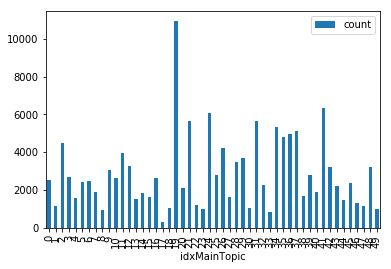

In [48]:
countTopDocs_pdf.plot.bar(x='idxMainTopic',y='count')